<a href="https://colab.research.google.com/github/mekaviari37/audio_analyzer_assemblyai/blob/main/speech_sample_app.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install hvplot

In [2]:
import requests
from IPython.display import JSON
import pandas as pd
import numpy as np
import time

# Visualization
from wordcloud import WordCloud, STOPWORDS
import plotly.express as px

# Panel/hvplot (holoviz)
import panel as pn
pn.extension()
import param
import hvplot.pandas

# Others
import pickle
from io import StringIO

In [3]:
API_KEY = "PUT YOUR API KEY HERE"

## Get audio transcription using AssemblyAI

In [19]:
# Submitting Files for Transcription
import requests
endpoint = "https://api.assemblyai.com/v2/transcript"
json = {
    "audio_url": "https://github.com/mekaviari37/audio_analyzer_assemblyai/blob/main/How_I_Would_Learn_to_Code.mp3?raw=true",
    "auto_highlights": True,
    "sentiment_analysis": True,
    "auto_chapters": True,
    "iab_categories": True,
}
headers = {
    "authorization": API_KEY,
    "content-type": "application/json"
}
response = requests.post(endpoint, json=json, headers=headers)
print(response.json())

{'id': '60e0q2ax3t-2e05-4766-b8f7-9532c78d0480', 'language_model': 'assemblyai_default', 'acoustic_model': 'assemblyai_default', 'language_code': 'en_us', 'status': 'queued', 'audio_url': 'https://github.com/mekaviari37/audio_analyzer_assemblyai/blob/main/How_I_Would_Learn_to_Code.mp3?raw=true', 'text': None, 'words': None, 'utterances': None, 'confidence': None, 'audio_duration': None, 'punctuate': True, 'format_text': True, 'dual_channel': None, 'webhook_url': None, 'webhook_status_code': None, 'webhook_auth': False, 'webhook_auth_header_name': None, 'speed_boost': False, 'auto_highlights_result': None, 'auto_highlights': True, 'audio_start_from': None, 'audio_end_at': None, 'word_boost': [], 'boost_param': None, 'filter_profanity': False, 'redact_pii': False, 'redact_pii_audio': False, 'redact_pii_audio_quality': None, 'redact_pii_policies': None, 'redact_pii_sub': None, 'speaker_labels': False, 'content_safety': False, 'iab_categories': True, 'content_safety_labels': {}, 'iab_categ

In [5]:
#  endpoint + "/" + response.json()["id"]

In [21]:
# Getting the Transcription Result
result_endpoint = endpoint + "/" + response.json()["id"]
headers_auth = {
    "authorization": API_KEY,
}
transcript_response = requests.get(result_endpoint, headers=headers_auth)
print(transcript_response.json())

# While loop for requesting transcription
while response.json()['status'] != "completed":
    response = requests.get(result_endpoint, headers=headers_auth)
    time.sleep(3)

{'id': '60e0q2ax3t-2e05-4766-b8f7-9532c78d0480', 'language_model': 'assemblyai_default', 'acoustic_model': 'assemblyai_default', 'language_code': 'en_us', 'status': 'completed', 'audio_url': 'https://github.com/mekaviari37/audio_analyzer_assemblyai/blob/main/How_I_Would_Learn_to_Code.mp3?raw=true', 'text': "I recently got an amazing opportunity. I've been learning jujitsu, and a friend offered to coach me in exchange for teaching him how to code. At this point in my life, where I'm trying to improve my jujitsu as quickly as possible, this was an incredible trade for me. In my personal opinion, I was all for it until I had to think about how I'd actually go about teaching someone how to code starting from nothing, I quickly realized that this was gonna be a lot harder than I thought. After all, it's been almost ten years since wrote my very first line of code. That's a pretty long time. Now, this video is about the very specific and detailed plan that I wrote for my friend to teach me t

In [27]:
# transcript_response.json()["sentiment_analysis_results"];

In [28]:
JSON(transcript_response.json())

<IPython.core.display.JSON object>

In [29]:
# Save pickle
with open('speech_data.pkl', 'wb') as f:
    pickle.dump(transcript_response.json().copy(), f)

## Dashboard components

In [30]:
# Load data pickle
with open('speech_data.pkl', 'rb') as f:
    data = pickle.load(f)

In [31]:
print(data)

{'id': '60e0q2ax3t-2e05-4766-b8f7-9532c78d0480', 'language_model': 'assemblyai_default', 'acoustic_model': 'assemblyai_default', 'language_code': 'en_us', 'status': 'completed', 'audio_url': 'https://github.com/mekaviari37/audio_analyzer_assemblyai/blob/main/How_I_Would_Learn_to_Code.mp3?raw=true', 'text': "I recently got an amazing opportunity. I've been learning jujitsu, and a friend offered to coach me in exchange for teaching him how to code. At this point in my life, where I'm trying to improve my jujitsu as quickly as possible, this was an incredible trade for me. In my personal opinion, I was all for it until I had to think about how I'd actually go about teaching someone how to code starting from nothing, I quickly realized that this was gonna be a lot harder than I thought. After all, it's been almost ten years since wrote my very first line of code. That's a pretty long time. Now, this video is about the very specific and detailed plan that I wrote for my friend to teach me t

### 0) Download transcript widget

In [32]:
# Create a StringIO buffer
buffer = StringIO()

# Check if data["text"] is not None before writing to the buffer
if data["text"] is not None:
    buffer.write(data["text"])
else:
    # Handle the case when data["text"] is None
    buffer.write("Default text")  # Replace "Default text" with your desired default value

buffer.seek(0)  # Move the buffer cursor to the beginning

0

In [33]:
transcript_download = pn.widgets.FileDownload(file=buffer,
                                              filename="transcript.txt",
                                              button_type='success')
transcript_download

FileDownload(button_type='success', file=<_io.StringIO o..., filename='transcript.txt', label='Download transcript.txt')

### 00) Audio play

In [34]:
audio_url = "https://github.com/mekaviari37/audio_analyzer_assemblyai/blob/main/How_I_Would_Learn_to_Code.mp3?raw=true"
audio_play = pn.pane.Audio(audio_url, name='Audio', time = 360)
audio_play

Audio(str, time=360)

### 1) Sentiment plot

In [35]:
sentiment = data["sentiment_analysis_results"]

In [36]:
sentiment_df = pd.DataFrame(sentiment)
sentiment_df

,text,start,end,sentiment,confidence,speaker
0,I recently got an amazing opportunity.,250,2110,POSITIVE,0.985436,None
1,"I've been learning jujitsu, and a friend offer...",2260,7262,POSITIVE,0.567717,None
2,"At this point in my life, where I'm trying to ...",7396,13294,POSITIVE,0.954535,None
3,"In my personal opinion, I was all for it until...",13332,22702,NEGATIVE,0.624869,None
4,"After all, it's been almost ten years since wr...",22836,26262,NEUTRAL,0.617327,None
...,...,...,...,...,...,...
142,They'll tell you something about what's wrong.,632082,633798,NEUTRAL,0.498572,None
143,"Also, Google the errors, and this will save yo...",633884,637042,POSITIVE,0.568509,None
144,"Finally, the third thing is to take it easy on...",637106,639366,NEUTRAL,0.523670,None
145,The only people that can't code are the ones t...,639468,643718,NEGATIVE,0.902655,None


In [37]:
sentiment_df_grouped = sentiment_df['sentiment'].value_counts()
sentiment_df_grouped

NEUTRAL     78
POSITIVE    54
NEGATIVE    15
Name: sentiment, dtype: int64

In [38]:
# Bar plot
sentiment_plot = sentiment_df_grouped.hvplot(title = "Sentences by Sentiment Category", kind="bar")
pn.Row(sentiment_plot)

Row
    [0] HoloViews(Bars, height=300, sizing_mode='fixed', width=700)

In [39]:
positive_df = sentiment_df[sentiment_df["sentiment"] == "POSITIVE"][["text", "sentiment"]]
negative_df = sentiment_df[sentiment_df["sentiment"] == "NEGATIVE"][["text", "sentiment"]]
neutral_df = sentiment_df[sentiment_df["sentiment"] == "NEUTRAL"][["text", "sentiment"]]

sentiment_tabs = pn.Tabs(('Sentiment overview', sentiment_plot),
                       ('Positive', pn.widgets.DataFrame(positive_df, autosize_mode='fit_columns', width=700, height=300)),
                       ('Negative', pn.widgets.DataFrame(negative_df, autosize_mode='fit_columns', width=700, height=300)),
                       ('Neutral', pn.widgets.DataFrame(neutral_df, autosize_mode='fit_columns', width=700, height=300))
                        )
sentiment_tabs

Tabs
    [0] HoloViews(Bars, height=300, name='Sentiment overview', sizing_mode='fixed', width=700)
    [1] DataFrame(autosize_mode='fit_columns', height=300, sizing_mode='fixed', value=                          ..., width=700)
    [2] DataFrame(autosize_mode='fit_columns', height=300, sizing_mode='fixed', value=                          ..., width=700)
    [3] DataFrame(autosize_mode='fit_columns', height=300, sizing_mode='fixed', value=                          ..., width=700)

## 2) Word cloud

In [40]:
stopwords = set(STOPWORDS)

In [43]:
transcript = data["text"]

In [44]:
transcript_lower = [item.lower() for item in str(transcript).split()]
transcript_lower;

In [45]:
all_words = ' '.join(transcript_lower)
all_words

"i recently got an amazing opportunity. i've been learning jujitsu, and a friend offered to coach me in exchange for teaching him how to code. at this point in my life, where i'm trying to improve my jujitsu as quickly as possible, this was an incredible trade for me. in my personal opinion, i was all for it until i had to think about how i'd actually go about teaching someone how to code starting from nothing, i quickly realized that this was gonna be a lot harder than i thought. after all, it's been almost ten years since wrote my very first line of code. that's a pretty long time. now, this video is about the very specific and detailed plan that i wrote for my friend to teach me the basics of coding for data science. since i did all the work for him, i figured i might as well share the details with you as well. here. there have been plenty of other great videos similar to this about how to start coding, and i've linked many of them in the description. again, those are great. but i t


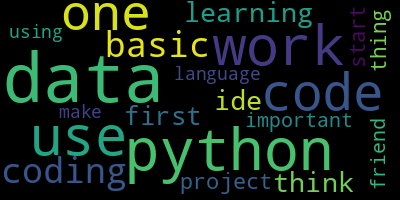

In [46]:
# Word cloud plot
wordcloud = WordCloud(background_color='black', stopwords = stopwords, max_words = 20,
                      colormap='viridis', collocations=False).generate(all_words)

wordcloud_plot = px.imshow(wordcloud)
# Remove labels on axes
wordcloud_plot.update_xaxes(showticklabels=False)
wordcloud_plot.update_yaxes(showticklabels=False)
wordcloud_plot

In [47]:
# Create interactive slider
class Controller(param.Parameterized):
    word_slider = param.Integer(30, bounds=(5, 50), step=5)

controller = Controller()

@pn.depends(controller.param.word_slider, watch=True)
def update_wordcloud(num_words):
    # Word cloud plot
    wordcloud = WordCloud(background_color='black', stopwords = stopwords, max_words = num_words,
                          colormap='viridis', collocations=False).generate(all_words)

    wordcloud_plot = px.imshow(wordcloud)
    # Remove labels on axes
    wordcloud_plot.update_xaxes(showticklabels=False)
    wordcloud_plot.update_yaxes(showticklabels=False)
    return wordcloud_plot

### 3) Auto chapter summary

In [48]:
chapters = data["chapters"]
chapters

[{'summary': 'A friend offered to coach me in exchange for teaching him how to code. This video is more focused on coding for data and it uses a very specific real world case study. At the end, I highlight the three most important things a new programmer should know.',
  'gist': 'How to Start Coding',
  'headline': 'A friend offered to coach me in exchange for teaching me how to code',
  'start': 250,
  'end': 57710},
 {'summary': 'About 48% of respondents use Python, while only about 5% use R. In industry, Python is a far more common language. What coding skills should my friend learn first?',
  'gist': 'Python vs R: The Skills You Need to Have',
  'headline': '48% of Stack Overflow respondents use Python, while only 5% use R',
  'start': 57780,
  'end': 272402},
 {'summary': "At the most basic level, beginner coding can be broken down into seven concepts. These include data types, variables, functions, loops and libraries. Most of the resources that I've linked in the description cov

In [49]:
chapter_summary = pn.widgets.StaticText(value=chapters[0]["summary"],
                                        width=1000,
                                        height_policy = "fit")
chapter_summary

StaticText(height_policy='fit', value='A friend offered to coach..., width=1000)

In [50]:
button = pn.widgets.Button(name=str(int(chapters[0]["start"]/1000)), button_type='primary')
button

Button(button_type='primary', name='0')

In [51]:
chapter_audio = pn.pane.Audio(audio_url, name='Audio', time = round(chapters[0]["start"]/1000))
chapter_audio

Audio(str)

In [52]:
# Create chapter summary layout
chapters_layout = pn.Column(pn.pane.Markdown("### Auto Chapter Summary"))

class ButtonAudio():
    def __init__(self, start_time):
        self.start_time = start_time
        self.button = pn.widgets.Button(name=str(int(self.start_time/1000)), button_type='primary', width=60)
        self.chapter_audio = pn.pane.Audio(audio_url, name='Audio', time = round(self.start_time/1000))
        self.button.on_click(self.move_audio_head)

    def move_audio_head(self, event):
        self.chapter_audio.time = self.start_time/1000

for chapter in chapters:
    chapter_summary = pn.widgets.StaticText(value=chapter["summary"], width=1000, height_policy = "fit")
    button_audio = ButtonAudio(chapter["start"])
    button = button_audio.button
    chapter_audio = button_audio.chapter_audio
    chapters_layout.append(pn.Row(pn.Column(button), pn.Column(chapter_audio), pn.Column(chapter_summary)))

chapters_layout

Column
    [0] Markdown(str)
    [1] Row
        [0] Column
            [0] Button(button_type='primary', name='0', width=60)
        [1] Column
            [0] Audio(str)
        [2] Column
            [0] StaticText(height_policy='fit', value='A friend offered to coach..., width=1000)
    [2] Row
        [0] Column
            [0] Button(button_type='primary', name='57', width=60)
        [1] Column
            [0] Audio(str, time=58)
        [2] Column
            [0] StaticText(height_policy='fit', value='About 48% of respondents ..., width=1000)
    [3] Row
        [0] Column
            [0] Button(button_type='primary', name='272', width=60)
        [1] Column
            [0] Audio(str, time=273)
        [2] Column
            [0] StaticText(height_policy='fit', value="At the most basic level, ..., width=1000)
    [4] Row
        [0] Column
            [0] Button(button_type='primary', name='522', width=60)
        [1] Column
            [0] Audio(str, time=522)
        [2] Column
            [0] StaticText(height_policy='fit', value="If you're interested in l..., width=1000)

### 4) Auto highlights

In [53]:
highlights = data["auto_highlights_result"]["results"]
highlights_df = pd.DataFrame(highlights)
highlights_df

,count,rank,text,timestamps
0,1,0.07,Python code,"[{'start': 270136, 'end': 270882}]"
1,7,0.06,data science,"[{'start': 33388, 'end': 33954}, {'start': 679..."
2,1,0.06,data science learning,"[{'start': 88988, 'end': 89782}]"
3,1,0.06,tangible data science skills,"[{'start': 470136, 'end': 471406}]"
4,3,0.06,data scientists,"[{'start': 82492, 'end': 83330}, {'start': 100..."
5,1,0.05,different data structures,"[{'start': 329480, 'end': 330450}]"
6,1,0.05,data types,"[{'start': 323272, 'end': 323982}]"
7,1,0.05,data frames,"[{'start': 412404, 'end': 412954}]"
8,1,0.05,other great videos,"[{'start': 38748, 'end': 39510}]"
9,2,0.05,other people,"[{'start': 540012, 'end': 540374}, {'start': 5..."


In [54]:
highlights_df_grouped = highlights_df.groupby(["count", "rank"])['text'].apply(", \n".join).reset_index()
highlights_df_grouped

,count,rank,text
0,1,0.04,many ides
1,1,0.05,"different data structures, \ndata types, \ndat..."
2,1,0.06,"data science learning, \ntangible data science..."
3,1,0.07,Python code
4,2,0.05,"other people, \nmany people"
5,3,0.04,object oriented programming
6,3,0.06,data scientists
7,6,0.04,projects
8,7,0.06,data science


In [55]:
# Scatter plot
highlights_plot = highlights_df_grouped.hvplot.points(x="count", y="rank",
                                                      padding=0.4, hover_cols="all",
                                                      width=1300, height=600,
                                                      size=50, title="Automatic Highlighted Words") *\
highlights_df_grouped.hvplot.labels(x="count", y="rank",
                                    text="text", text_baseline="top",
                                    hover=False).opts(fontscale=1.5)

pn.Row(highlights_plot)

Row
    [0] HoloViews(Overlay, height=600, sizing_mode='fixed', width=1300)

## Dashboard

In [56]:
# Define the URL for the thumbnail image
thumbnail_url = "https://raw.githubusercontent.com/mekaviari37/audio_analyzer_assemblyai/main/kenjee_thumbnail.png"

# Create the Markdown panes and the PNG pane for the thumbnail
sidebar = [
    pn.pane.Markdown("# Explore audio content"),
    pn.pane.Markdown("#### This app analyzes the content of your audio file, including sentiment, wordcloud, automatic content summary and highlights using AssemblyAI API."),
    pn.pane.Markdown("#### This example is based on the audio content of Ken Jee's Youtube video on how to learn to code."),
    pn.pane.PNG(thumbnail_url, sizing_mode="scale_both"),
    pn.pane.Markdown("### [Link to video!](https://www.youtube.com/watch?v=EBjYqC3aNTA&t=311s)"),
    pn.pane.Markdown("### Download transcript:"),
    transcript_download
]

# Create the template
template = pn.template.FastListTemplate(
    title='Audio Content Explorer',
    sidebar=sidebar,
    main=[
        pn.Row(
            pn.Column(sentiment_tabs),
            pn.Column(
                pn.Row(controller.param.word_slider),
                pn.Row(update_wordcloud, title="WordCloud of Speech Content")
            )
        ),
        pn.Row(chapters_layout),
        pn.Row(highlights_plot, title="Automatic Highlights")
    ],
    accent_base_color="#88d8b0",
    header_background="#c0b9dd",
)

# Show the template
template.show()


Launching server at http://localhost:45041


In [67]:
import panel as pn
pn.extension()

# Define the URL for the thumbnail image
thumbnail_url = "https://raw.githubusercontent.com/mekaviari37/audio_analyzer_assemblyai/main/kenjee_thumbnail.png"

# Create the Markdown panes and the PNG pane for the thumbnail
sidebar = [
    pn.pane.Markdown("# Explore audio content"),
    pn.pane.Markdown("#### This app analyzes the content of your audio file, including sentiment, wordcloud, automatic content summary, and highlights using AssemblyAI API."),
    pn.pane.Markdown("#### This example is based on the audio content of Ken Jee's Youtube video on how to learn to code."),
    pn.pane.PNG(thumbnail_url, sizing_mode="scale_both"),
    pn.pane.Markdown("### [Link to video!](https://www.youtube.com/watch?v=EBjYqC3aNTA&t=311s)"),
    pn.pane.Markdown("### Download transcript:"),
    transcript_download
]

# Create the template
template = pn.template.FastListTemplate(
    title='Audio Content Explorer',
    sidebar=sidebar,
    main=[
        pn.Row(
            pn.Column(sentiment_tabs, name="Sentiment"),
            pn.Column(
                pn.Row(controller.param.word_slider),
                pn.Row(update_wordcloud, name="WordCloud of Speech Content")
            )
        ),
        pn.Row(chapters_layout),
        pn.Row(highlights_plot, name="Automatic Highlights")
    ],
    accent_base_color="#88d8b0",
    header_background="#c0b9dd",
)

# Show the template
template.show(port=8000)  # Change the port number to 8000 or any other available port


Launching server at http://localhost:8000
